# Train occupation classifiers and gender classifier using bag-of-words representation

## load bios

In [ ]:
%pylab inline
from collections import Counter
import http.client, urllib.parse, json, time, sys
from glob import glob
from bs4 import BeautifulSoup as Soup
sys.path.append("../words")
import we
from sklearn.svm import LinearSVC, SVC
import numpy as np
import re, sys
import random
import scipy
from adjustText import adjust_text

import statsmodels.stats.proportion
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import sklearn.feature_selection 
from nltk.stem.porter import *
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import time
import os, json
import re
import textblob
import langdetect
import pickle as pkl
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from bs4 import BeautifulSoup
from random import randint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import matplotlib.pyplot as plt
import we
pylab.rcParams['figure.figsize'] = (10, 6)


# Data cleaning and preprocessing

### Load CommonCrawl data and clean

inv_titles = {'Accountant': 'accountant',
 'Architect': 'architect',
 'Assistant Professor': 'professor',
 'Associate Professor': 'professor',
 'Attorney': 'attorney',
 'Certified Personal Trainer': 'personal_trainer',
 'Certified Public Accountant': 'accountant',
 'Chiropractor': 'chiropractor',
 'Comedian': 'comedian',
 'Composer': 'composer',
 'Cpa': 'accountant',
 'Dentist': 'dentist',
 'Dietitian': 'dietitian',
#  'Dj': 'dj',
 'Filmmaker': 'filmmaker',
 'Interior Designer': 'interior_designer',
 'Journalist': 'journalist',
 'Landscape Architect': 'landscape_architect',
 'Model': 'model',
 'Neurosurgeon': 'surgeon',
 'Nurse': 'nurse',
 'Nutritionist': 'dietitian',
 'Orthopedic Surgeon': 'surgeon',
 'Painter': 'painter',
 'Paralegal': 'paralegal',
 'Pastor': 'pastor',
 'Personal Trainer': 'personal_trainer',
 'Photographer': 'photographer',
 'Physician': 'physician',
 'Plastic Surgeon': 'surgeon',
 'Poet': 'poet',
 'Psychologist': 'psychologist',
 'Psychotherapist': 'psychologist',
#  'Rapper': 'rapper',
 'Senior Software Engineer': 'software_engineer',
 'Software Engineer': 'software_engineer',
 'Surgeon': 'surgeon',
 'Teacher': 'teacher',
 'Trial Attorney': 'attorney',
 'Trial Lawyer': 'attorney',
 'Yoga Instructor': 'yoga_teacher',
 'Yoga Teacher': 'yoga_teacher'}


In [72]:
words = np.array(vectorizer.get_feature_names())
np.save('results/words.npy',words)

In [4]:
def pred_clf(X, Y, G, X_pred=None, X_pred2=None, data_augm = False, subsample = False, random_state=42,balanced=False,sweights=None):
    if sweights is not None:
        clf = sklearn.linear_model.SGDClassifier(loss='log')
    
    else:
        if balanced:
            clf = sklearn.linear_model.SGDClassifier(loss='log',class_weight='balanced', random_state=42)
#             clf = linear_model.LogisticRegression(penalty = 'l2', class_weight='balanced', random_state=42)
        else:
            clf = linear_model.LogisticRegression(penalty = 'l2', random_state=42,) 
    np.random.seed(random_state)
    random.seed(random_state)
    
    X_train, X_val, X_test = X
    Y_train, Y_val, Y_test = Y
    G_train, G_val, G_test = G
    
    Y, G = asarray(Y), asarray(G)
    
    if X_pred is None:
        X_pred = X_test
    
    #cross validation partitions for training and testing
    results = {'y_pred':[], 'y_pred_prob':[], 'y_pred_correct':[] , 'y_pred2':[], 'y_pred2_prob':[], 'y_pred2_correct':[],'y_pred_diff':[] }
    
    if data_augm:
        X_train = hstack((X_train, invert_gender(X_train, vectorizer)))
        Y_train = hstack((Y_train,Y_train))
#     clf = GridSearch(model = clf, num_threads = 4,param_grid=params)
#     clf.fit(X_train, Y_train, params, X_val, Y_val)
    print("clf fit")
    if sweights is not None:
        clf.fit(X_train, Y_train, sample_weight=sweights)

    else:
        clf.fit(X_train, Y_train)
   
    y_pred = clf.predict(X_test)
    y_pred_proba =clf.predict_proba(X_test)
        
    results['y_pred'] = y_pred
    results['y_pred_prob'] = y_pred_proba
    results['y_pred_correct'] = y_pred== array(Y_test)
        
    if X_pred2 is not None:
        y_pred2 = clf.predict(X_pred2)
        y_pred2_proba =clf.predict_proba(X_pred2)
        results['y_pred2'] = y_pred2
        results['y_pred2_prob'] = y_pred2_proba
        results['y_pred2_correct'] = y_pred2== array(Y_test)
        results['y_pred_diff'] = y_pred2_proba-y_pred_proba
        
    return results, clf


In [6]:
sorted_occs = ['accountant', 'architect', 'attorney', 'chiropractor', 'comedian', 'composer',
 'dentist', 'dietitian', 'dj', 'filmmaker', 'interior_designer', 'journalist',
 'model', 'nurse', 'painter', 'paralegal', 'pastor', 'personal_trainer',
 'photographer', 'physician', 'poet', 'professor', 'psychologist', 'rapper',
 'software_engineer', 'surgeon', 'teacher', 'yoga_teacher']

In [5]:
bios = pkl.load(open('biosbias/data/BIOS_inferred.pkl','rb'))
# def load_data(filename):
data = bios
print(f'Data: {len(data)}')

# stratified split
labels_all = [bio['title'] for bio in data]
bios_data_train_val, bios_data_test = train_test_split(data, test_size=0.20, random_state=42, stratify=labels_all)

labels_train_val = [bio['title'] for bio in bios_data_train_val]
bios_data_train, bios_data_val = train_test_split(bios_data_train_val, test_size=0.25, random_state=42, stratify=labels_train_val)

# return bios_data_train, bios_data_val, bios_data_test


Data: 397907


In [7]:
_f = Counter([p["title"] for p in bios_data_train if p["gender"]=="F"])
_m = Counter([p["title"] for p in bios_data_train if p["gender"]=="M"])
_t = Counter([p["title"] for p in bios_data_train])
fem = {t:_f[t]/float(_t[t]) for t in sorted_occs}

titles = sorted_occs.copy()
titles.sort(key=lambda t: fem[t])

In [273]:
X_test = vectorizer.transform([p["bio"] for p in bios_data_test])


In [9]:


X_val = vectorizer.transform([p["bio"] for p in bios_data_val])
X_test = vectorizer.transform([p["bio"] for p in bios_data_test])


G_train = [p["gender"] for p in bios_data_train]
G_val = [p["gender"] for p in bios_data_val]
G_test = [p["gender"] for p in bios_data_test]

### FEMALE


G_train = [p["gender"] for p in bios_data_train]
G_val = [p["gender"] for p in bios_data_val]
G_test = [p["gender"] for p in bios_data_test]




f_bios_train = [p for p in bios_data_train if p['gender']=='F']
f_bios_val = [p for p in bios_data_val if p['gender']=='F']
f_bios_test = [p for p in bios_data_test if p['gender']=='F']


f_X_train = vectorizer.transform([p["bio"] for p in f_bios_train])
f_X_val = vectorizer.transform([p["bio"] for p in f_bios_val])
f_X_test = vectorizer.transform([p["bio"] for p in f_bios_test])


f_G_train = [p["gender"] for p in f_bios_train]
f_G_val = [p["gender"] for p in f_bios_val]
f_G_test = [p["gender"] for p in f_bios_test]

In [ ]:


m_bios_train = [p for p in bios_data_train if p['gender']=='M']
m_bios_val = [p for p in bios_data_val if p['gender']=='M']
m_bios_test = [p for p in bios_data_test if p['gender']=='M']


m_X_train = vectorizer.transform([p["bio"] for p in m_bios_train])
m_X_val = vectorizer.transform([p["bio"] for p in m_bios_val])
m_X_test = vectorizer.transform([p["bio"] for p in m_bios_test])


m_G_train = [p["gender"] for p in m_bios_train]
m_G_val = [p["gender"] for p in m_bios_val]
m_G_test = [p["gender"] for p in m_bios_test]



## train occupation classifiers

In [60]:
occs = ["surgeon", "software_engineer", "composer", "pastor", "comedian", "architect", "chiropractor", "accountant", "attorney", "filmmaker", "physician", "dentist", "photographer", "professor", "painter", "journalist", "poet", "personal_trainer", "teacher", "psychologist",  "model", "interior_designer", "yoga_teacher", "nurse", "dietitian"]
for target_occ in occs:
    m_Y_train = [p["title"]==target_occ for p in m_bios_train]
    m_Y_val = [p["title"]==target_occ for p in m_bios_val]
    m_Y_test = [p["title"]==target_occ for p in m_bios_test]
    
    pred_bow_m, clm_bow_m = pred_clf([m_X_train, m_X_val, m_X_test], [m_Y_train, m_Y_val, m_Y_test], [m_G_train,m_G_val,m_G_test],balanced=True)
    occ_classers[target_occ]['clm_bow_m'] = clm_bow_m
    occ_classers[target_occ]['pred_bow_m'] = pred_bow_m

/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


In [11]:
# Train Occupation classifiers

occ_classers = {}

occs = ["surgeon", "software_engineer", "composer", "pastor", "comedian", "architect", "chiropractor", "accountant", "attorney", "filmmaker", "physician", "dentist", "photographer", "professor", "painter", "journalist", "poet", "personal_trainer", "teacher", "psychologist",  "model", "interior_designer", "yoga_teacher", "nurse", "dietitian"]
for target_occ in occs:
    Y_train = [p["title"]==target_occ for p in bios_data_train]

    Y_val = [p["title"]==target_occ for p in bios_data_val]

    Y_test = [p["title"]==target_occ for p in bios_data_test]
    
    f_Y_train = [p["title"]==target_occ for p in f_bios_train]
    f_Y_val = [p["title"]==target_occ for p in f_bios_val]
    f_Y_test = [p["title"]==target_occ for p in f_bios_test]
    
    
    pred_bow_joint, clf_bow_joint = pred_clf([X_train, X_val, X_test], [Y_train, Y_val, Y_test], [G_train,G_val,G_test],balanced=True)
    
    pred_bow_f, clf_bow_f = pred_clf([f_X_train, f_X_val, f_X_test], [f_Y_train, f_Y_val, f_Y_test], [f_G_train,f_G_val,f_G_test],balanced=True)
    
    
    occ_classers[target_occ] = {}
    occ_classers[target_occ]['clf_bow_joint'] = clf_bow_joint
    occ_classers[target_occ]['pred_bow_joint'] = pred_bow_joint
    occ_classers[target_occ]['clf_bow_f'] = clf_bow_f
    occ_classers[target_occ]['pred_bow_f'] = pred_bow_f

/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


In [12]:
target_occ = 'all'
Y_train = [p["title"] for p in bios_data_train]

Y_val = [p["title"] for p in bios_data_val]

Y_test = [p["title"] for p in bios_data_test]

f_Y_train = [p["title"] for p in f_bios_train]
f_Y_val = [p["title"] for p in f_bios_val]
f_Y_test = [p["title"] for p in f_bios_test]


pred_bow_joint, clf_bow_joint = pred_clf([X_train, X_val, X_test], [Y_train, Y_val, Y_test], [G_train,G_val,G_test],balanced=True)

pred_bow_f, clf_bow_f = pred_clf([f_X_train, f_X_val, f_X_test], [f_Y_train, f_Y_val, f_Y_test], [f_G_train,f_G_val,f_G_test],balanced=True)


occ_classers[target_occ] = {}
occ_classers[target_occ]['clf_bow_joint'] = clf_bow_joint
occ_classers[target_occ]['pred_bow_joint'] = pred_bow_joint
occ_classers[target_occ]['clf_bow_f'] = clf_bow_f
occ_classers[target_occ]['pred_bow_f'] = pred_bow_f

/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


In [327]:
pkl.dump(occ_classers,open('results/bow_occ_classers.pkl','wb'))

In [302]:
m_Y_train = [p["title"] for p in m_bios_train]
m_Y_val = [p["title"] for p in m_bios_val]
m_Y_test = [p["title"] for p in m_bios_test]
pred_bow_m, clm_bow_m = pred_clf([m_X_train, m_X_val, m_X_test], [m_Y_train, m_Y_val, m_Y_test], [m_G_train,m_G_val,m_G_test],balanced=True)


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


# Gender classifiers

In [30]:


# unbalanced
unbalanced_gender_clf = sklearn.linear_model.SGDClassifier(loss='log')
unbalanced_gender_clf.fit(X_train, G_train)
pkl.dump(unbalanced_gender_clf,open('results/bow_unbal_g.pkl','wb'))


# balanced

occs_full = np.unique([p['title'] for p in bios_data_train])
#make sample weights
sample_weights=[]
valdict = {}
for t in occs_full:
        fval = _m[t] / max(_f[t],_m[t])
        mval = _f[t] / max(_f[t],_m[t])
        valdict[t] = {}
        valdict[t]['F'] = fval
        valdict[t]['M'] = mval
    
# for :
sample_weights = [valdict[p['title']][p['gender']] for p in bios_data_train]

# _f, 

balanced_gender_clf = sklearn.linear_model.SGDClassifier(loss='log')
balanced_gender_clf.fit(X_train, G_train,sample_weight=sample_weights)
pkl.dump(balanced_gender_clf,open('results/bow_bal_g.pkl','wb'))


In [15]:
!ls results

bow_bal_g.pkl	      we_bal_g.pkl		     we_unbal_g.pkl
bow_occ_classers.pkl  we_occ_classers.pkl
bow_unbal_g.pkl       we_single_gender_classers.pkl


In [21]:
single_gender_classers = {}
occs = ["surgeon", "software_engineer", "composer", "pastor", "comedian", "architect", "chiropractor", "accountant", "attorney", "filmmaker", "physician", "dentist", "photographer", "professor", "painter", "journalist", "poet", "personal_trainer", "teacher", "psychologist",  "model", "interior_designer", "yoga_teacher", "nurse", "dietitian"]

for occ in occs:
# #     print(occ)
    cand_X = [i for i,p in enumerate(bios_data_train) if p['title']==occ]
# #     irrev_X_train = decorr_with_occ(np.array(X_train)[cand_X], occ)
#     X_test = vectorizer.transform([p["bio"] for p in bios_data_test])

    temp_bios = np.array(bios_data_train)[cand_X]
    temp_X = vectorizer.transform([p["bio"] for p in temp_bios])

    balanced_gender_clf = sklearn.linear_model.SGDClassifier(loss='log')
    balanced_gender_clf.fit(temp_X,np.array(G_train)[cand_X])
    
    single_gender_classers[occ] = balanced_gender_clf
#
pkl.dump(single_gender_classers,open('results/bow_single_gender_classers.pkl','wb'))

In [ ]:
bios_data_train = pkl.load(open("bios_data_train_wo.pkl","rb"))
X_train = pkl.load(open('xtrain_bow.pkl','rb'))
X_test = pkl.load(open('X_test_bow.pkl','rb'))


In [22]:
pkl.dump(bios_data_train,open("bios_data_train_wo.pkl","wb"))
pkl.dump(X_train,open('xtrain_bow.pkl','wb'))
pkl.dump(X_test,open('xtest_bow.pkl','wb'))

# Correlation plots

In [153]:
# covariances with gender clasifier
f_frac = np.load('results/f_frac.npy')
y_preds_eo = pkl.load(open('results/bow_eo_y_preds.pkl','rb'))
joint_corr_full = []
decoupled_corr_full = []
eo_corr_full = []
for target_occ in occs:
    
    
    cand_women = [p for p in bios_data_test if p["title"]==target_occ and p['gender']=='F']
#     cand_women_X =  single_vectorizers[target_occ].transform([p["bio"] for p in cand_women])
    
    cand_women_X_full =  vectorizer.transform([p["bio"] for p in cand_women])
    
    gender_probs = balanced_gender_clf.predict_proba(cand_women_X_full)[:,0]
    occ_probs = occ_classers[target_occ]['clf_bow_joint'].predict_proba(cand_women_X_full)[:,1]
    
    
    
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    joint_corr_full.append(corr)
    
    occ_probs = occ_classers[target_occ]['clf_bow_f'].predict_proba(cand_women_X_full)[:,1]
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    decoupled_corr_full.append(corr)
#     decoupled_cov.append(cov)
    
    cand_women_inds = np.array([i for i,p in enumerate(bios_data_test) if p["title"]==target_occ and p['gender']=='F'])
    occ_probs =  y_preds_eo[target_occ][cand_women_inds][:,1]
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    eo_corr_full.append(corr)


In [408]:
# SPEARMAN
from scipy.stats import spearmanr
# covariances with gender clasifier
f_frac = np.load('results/f_frac.npy')
y_preds_eo = pkl.load(open('results/bow_eo_y_preds.pkl','rb'))
joint_corr_full = []
decoupled_corr_full = []
pr_corr_full = []
for target_occ in occs:
    
    
    cand_women = [p for p in bios_data_test if p["title"]==target_occ and p['gender']=='F']
#     cand_women_X =  single_vectorizers[target_occ].transform([p["bio"] for p in cand_women])
    
    cand_women_X_full =  vectorizer.transform([p["bio"] for p in cand_women])
    
    gender_probs = balanced_gender_clf.predict_proba(cand_women_X_full)[:,0]
    occ_probs = occ_classers[target_occ]['clf_bow_joint'].predict_proba(cand_women_X_full)[:,1]
    
    
    
    corr = spearmanr(occ_probs,gender_probs)[0]
    joint_corr_full.append(corr)
    
    occ_probs = occ_classers[target_occ]['clf_bow_f'].predict_proba(cand_women_X_full)[:,1]
    corr = spearmanr(occ_probs,gender_probs)[0]
    decoupled_corr_full.append(corr)
#     decoupled_cov.append(cov)
    
    cand_women_inds = np.array([i for i,p in enumerate(bios_data_test) if p["title"]==target_occ and p['gender']=='F'])
    occ_probs =  occ_classers[target_occ]['clf_bow_joint_sampleweights'].predict_proba(cand_women_X_full)[:,1]
    corr = spearmanr(occ_probs,gender_probs)[0]
    pr_corr_full.append(corr)


In [415]:

print(np.cov(f_frac,joint_corr_full[:25])[0,1])
print(np.cov(f_frac,decoupled_corr_full[:25])[0,1])
print(np.cov(f_frac,pr_corr_full[:25])[0,1])

0.029388894783363904
0.01957441017331686
0.0262263870666854


In [416]:

print(np.cov(f_frac,joint_corr[:25])[0,1])
print(np.cov(f_frac,decoupled_corr[:25])[0,1])
print(np.cov(f_frac,pr_corr[:25])[0,1])

0.01686213282810397
0.008099761247851073
0.014880010283093804


Text(0.5, 1.0, 'BOW')

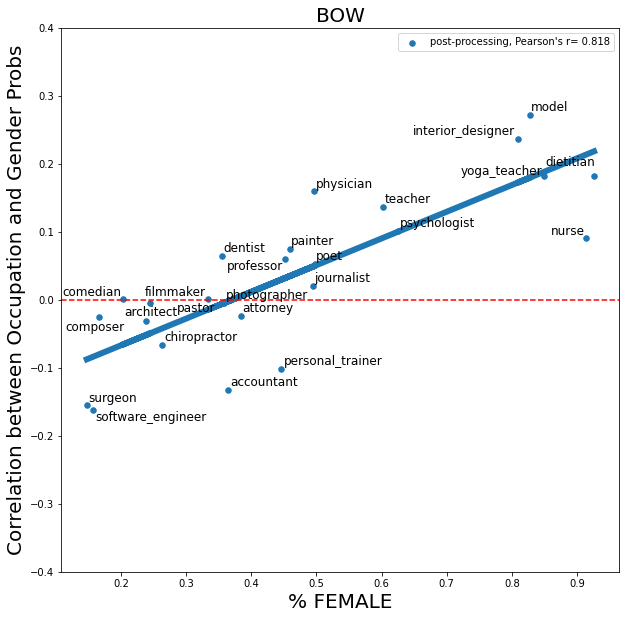

In [154]:
pylab.rcParams['figure.figsize'] = (10, 10)
xs = np.array(f_frac).reshape(-1,)

m, b = np.polyfit(xs, np.array(joint_corr_full).reshape(-1,), 1)
plt.scatter(f_frac,joint_corr_full,marker='o',s=30,label='post-processing, Pearson\'s r= %.3f'%(scipy.stats.pearsonr( f_frac,joint_corr_full)[0]))
plt.plot(xs, m*xs+ b,linewidth=6)

plt.legend()

plt.axhline(y=0, color='r', linestyle='dashed')


x_label = "% FEMALE"
y_label = 'Correlation between Occupation and Gender Probs'
texts = [plt.text(x,y,l,size=12) for x, y, l in zip(f_frac, joint_corr_full, occs)]
adjust_text(texts)
xlabel(x_label,size = 20 )
ylabel(y_label, size=20)
plt.ylim([-0.4, 0.4])
plt.title("BOW",fontsize=20)
    

    

Text(0.5, 1.0, 'BOW (F only)')

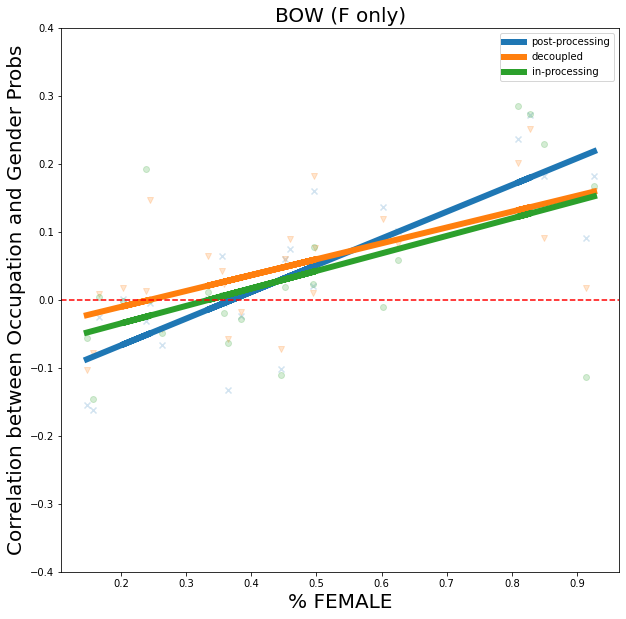

In [155]:


pylab.rcParams['figure.figsize'] = (10, 10)
xs = np.array(f_frac).reshape(-1,)

m, b = np.polyfit(xs, np.array(joint_corr_full).reshape(-1,), 1)
plt.scatter(f_frac,joint_corr_full,marker='x',alpha=0.2)
plt.plot(xs, m*xs+ b,linewidth=6,label='post-processing')

m, b = np.polyfit(xs, np.array(decoupled_corr_full).reshape(-1,), 1)
plt.scatter(f_frac,decoupled_corr_full,marker='v',alpha=0.2)
plt.plot(xs, m*xs+ b,linewidth=6,label='decoupled')


m, b = np.polyfit(xs, np.array(eo_corr_full).reshape(-1,), 1)
plt.scatter(f_frac,eo_corr_full,alpha=0.2)
plt.plot(xs, m*xs+ b,linewidth=6,label='in-processing')
plt.legend()


plt.axhline(y=0, color='r', linestyle='dashed')

x_label = "% FEMALE"
y_label = 'Correlation between Occupation and Gender Probs'
# texts = [plt.text(x,y,l) for x, y, l in zip(f_frac, decoupled_corr_full, occs)]
adjust_text(texts)
xlabel(x_label,size = 20 )
ylabel(y_label, size=20)
plt.ylim([-0.4, 0.4])
plt.title("BOW (F only)",fontsize=20)
    

    

In [414]:
# pearson's correlations
print(scipy.stats.spearmanr(f_frac,joint_corr_full)[0])
print(scipy.stats.spearmanr(f_frac,decoupled_corr_full)[0])
print(scipy.stats.spearmanr(f_frac,pr_corr_full)[0])

# pearson's correlations with g^irrev
print(scipy.stats.spearmanr(f_frac,joint_corr)[0])
print(scipy.stats.spearmanr(f_frac,decoupled_corr)[0])
print(scipy.stats.spearmanr(f_frac,pr_corr)[0])

0.7646153846153846
0.5876923076923077
0.6123076923076923
0.5884615384615385
0.3253846153846154
0.46384615384615385


In [413]:
# pearson's correlations with g^irrev
print(scipy.stats.pearsonr(f_frac,joint_corr)[0])
print(scipy.stats.pearsonr(f_frac,decoupled_corr)[0])
print(scipy.stats.pearsonr(f_frac,pr_corr)[0])

0.5517851128749864
0.2801622038393851
0.500521628247908


In [62]:
# covariance for all people in occupation
f_frac = np.load('results/f_frac.npy')
y_preds_eo = pkl.load(open('results/bow_eo_y_preds.pkl','rb'))
joint_corr_full = []
decoupled_corr_full = []
eo_corr_full = []
for target_occ in occs:
    
    
    cand_women = [p for p in bios_data_test if p["title"]==target_occ and p['gender']=='F']
    cand_women_len = len(cand_women)
    cand_women.extend([p for p in bios_data_test if p["title"]==target_occ and p['gender']=='M'])
#     cand_women_X =  single_vectorizers[target_occ].transform([p["bio"] for p in cand_women])
    
    cand_women_X_full =  vectorizer.transform([p["bio"] for p in cand_women])
    
    gender_probs = balanced_gender_clf.predict_proba(cand_women_X_full)[:,0]
    occ_probs = occ_classers[target_occ]['clf_bow_joint'].predict_proba(cand_women_X_full)[:,1]
    
    
    
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    joint_corr_full.append(corr)
    
    
    

    
    occ_probs = list(occ_classers[target_occ]['clf_bow_f'].predict_proba(cand_women_X_full[:cand_women_len])[:,1])
    occ_probs.extend(list(occ_classers[target_occ]['clm_bow_m'].predict_proba(cand_women_X_full[cand_women_len:])[:,1]))
    
    corr = scipy.stats.pearsonr(np.array(occ_probs),gender_probs)[0]
    decoupled_corr_full.append(corr)
#     decoupled_cov.append(cov)
    
    cand_women_inds = np.array([i for i,p in enumerate(bios_data_test) if p["title"]==target_occ])
    occ_probs =  y_preds_eo[target_occ][cand_women_inds][:,1]
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    eo_corr_full.append(corr)

    

Text(0.5, 1.0, 'BOW (all people in occupation)')

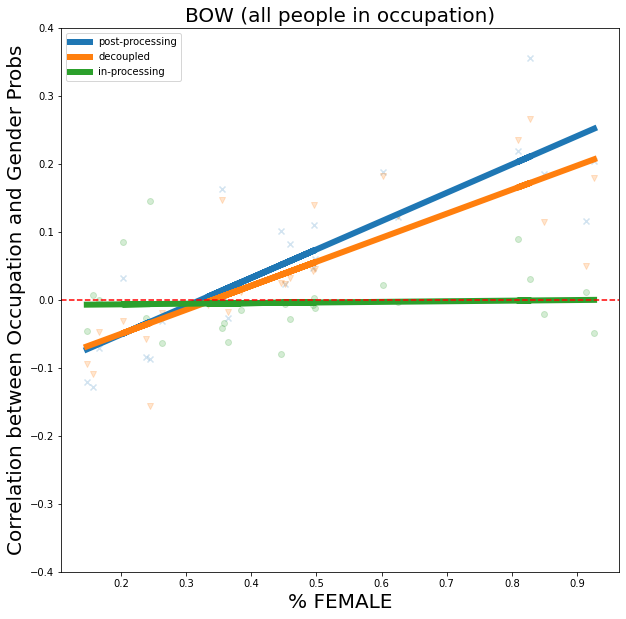

In [63]:

pylab.rcParams['figure.figsize'] = (10, 10)
xs = np.array(f_frac).reshape(-1,)

m, b = np.polyfit(xs, np.array(joint_corr_full).reshape(-1,), 1)
plt.scatter(f_frac,joint_corr_full,marker='x',alpha=0.2)
plt.plot(xs, m*xs+ b,linewidth=6,label='post-processing')

m, b = np.polyfit(xs, np.array(decoupled_corr_full).reshape(-1,), 1)
plt.scatter(f_frac,decoupled_corr_full,marker='v',alpha=0.2)
plt.plot(xs, m*xs+ b,linewidth=6,label='decoupled')


m, b = np.polyfit(xs, np.array(eo_corr_full).reshape(-1,), 1)
plt.scatter(f_frac,eo_corr_full,alpha=0.2)
plt.plot(xs, m*xs+ b,linewidth=6,label='in-processing')
plt.legend()


plt.axhline(y=0, color='r', linestyle='dashed')

x_label = "% FEMALE"
y_label = 'Correlation between Occupation and Gender Probs'
# texts = [plt.text(x,y,l) for x, y, l in zip(f_frac, decoupled_corr_full, occs)]
adjust_text(texts)
xlabel(x_label,size = 20 )
ylabel(y_label, size=20)
plt.ylim([-0.4, 0.4])
plt.title("BOW (all people in occupation)",fontsize=20)
    

    

In [405]:
# covariance for men in occupation
f_frac = np.load('results/f_frac.npy')
y_preds_eo = pkl.load(open('results/bow_eo_y_preds.pkl','rb'))
joint_corr_full = []
decoupled_corr_full = []
eo_corr_full = []
for target_occ in occs:
    
    
    cand_women = [p for p in bios_data_test if p["title"]==target_occ and p['gender']=='M']
    cand_women_X_full =  vectorizer.transform([p["bio"] for p in cand_women])
    
    gender_probs = balanced_gender_clf.predict_proba(cand_women_X_full)[:,0]
    occ_probs = occ_classers[target_occ]['clf_bow_joint'].predict_proba(cand_women_X_full)[:,1]
    
    
    
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    joint_corr_full.append(corr)
    
    occ_probs = occ_classers[target_occ]['clm_bow_m'].predict_proba(cand_women_X_full)[:,1]
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    decoupled_corr_full.append(corr)
    
    cand_women_inds = np.array([i for i,p in enumerate(bios_data_test) if p["title"]==target_occ and p['gender']=='M'])
    occ_probs =  y_preds_eo[target_occ][cand_women_inds][:,1]
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    eo_corr_full.append(corr)

    

Text(0.5, 1.0, 'BOW (M only)')

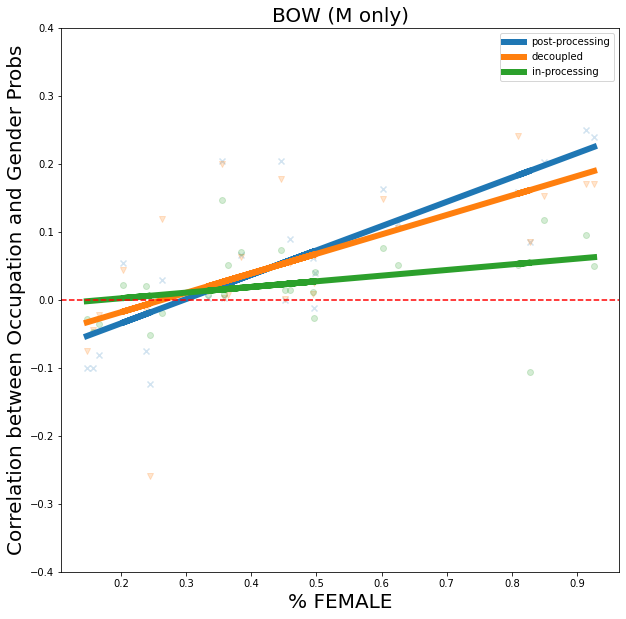

In [66]:

pylab.rcParams['figure.figsize'] = (10, 10)
xs = np.array(f_frac).reshape(-1,)

m, b = np.polyfit(xs, np.array(joint_corr_full).reshape(-1,), 1)
plt.scatter(f_frac,joint_corr_full,marker='x',alpha=0.2)
plt.plot(xs, m*xs+ b,linewidth=6,label='post-processing')

m, b = np.polyfit(xs, np.array(decoupled_corr_full).reshape(-1,), 1)
plt.scatter(f_frac,decoupled_corr_full,marker='v',alpha=0.2)
plt.plot(xs, m*xs+ b,linewidth=6,label='decoupled')


m, b = np.polyfit(xs, np.array(eo_corr_full).reshape(-1,), 1)
plt.scatter(f_frac,eo_corr_full,alpha=0.2)
plt.plot(xs, m*xs+ b,linewidth=6,label='in-processing')
plt.legend()


plt.axhline(y=0, color='r', linestyle='dashed')

x_label = "% FEMALE"
y_label = 'Correlation between Occupation and Gender Probs'
# texts = [plt.text(x,y,l) for x, y, l in zip(f_frac, decoupled_corr_full, occs)]
adjust_text(texts)
xlabel(x_label,size = 20 )
ylabel(y_label, size=20)
plt.ylim([-0.4, 0.4])
plt.title("BOW (M only)",fontsize=20)
    

    

## train task-irrelevant gender classifiers

In [92]:
# load chi scores
f_chi = pkl.load(open('results/f_chi.pkl','rb'))
m_chi = pkl.load(open('results/m_chi.pkl','rb'))



In [95]:
# threshold for determining task relevance
from scipy.stats import chi2
prob = 0.99
critical = chi2.ppf(prob, 1)
thr = critical

In [98]:
# train classifiers and save vocabularies
thr = critical
chi_gender_classers = {}
chi_vectorizers = {}
occs = ["surgeon", "software_engineer", "composer", "pastor", "comedian", "architect", "chiropractor", "accountant", "attorney", "filmmaker", "physician", "dentist", "photographer", "professor", "painter", "journalist", "poet", "personal_trainer", "teacher", "psychologist",  "model", "interior_designer", "yoga_teacher", "nurse", "dietitian"]

for occ in occs:
    
    print(occ)

        
    indset =[i for i,x in enumerate(f_chi[occ]) if x[0][0]<critical and m_chi[occ][i][0][0]<critical]

    print(len(list(indset)))
    irrev_chi_words = words[list(indset)]
    
    irrev_chi_vectorizer = CountVectorizer(analyzer='word',min_df=0.001,binary=False,vocabulary=irrev_chi_words)
    irrev_chi_X_train = irrev_chi_vectorizer.fit_transform([p["bio"] for p in bios_data_train])
    irrev_chi_X_val = irrev_chi_vectorizer.transform([p["bio"] for p in bios_data_val])
    irrev_chi_X_test = irrev_chi_vectorizer.transform([p["bio"] for p in bios_data_test])

    balanced_gender_clf = sklearn.linear_model.SGDClassifier(loss='log')
    balanced_gender_clf.fit(irrev_chi_X_train, G_train,sample_weight=sample_weights)
    
    chi_gender_classers[occ] = {}
    chi_gender_classers[occ][thr] = balanced_gender_clf
    chi_vectorizers[occ] = {}
    chi_vectorizers[occ][thr] = irrev_chi_vectorizer

surgeon
1479
software_engineer
2285
composer
2289
pastor
2967
comedian
2699
architect
2203
chiropractor
2932
accountant
2526
attorney
1184
filmmaker
2300
physician
525
dentist
1122
photographer
1140
professor
703
painter
2033
journalist
1518
poet
2277
personal_trainer
3209
teacher
1715
psychologist
1881
model
1846
interior_designer
3154
yoga_teacher
3003
nurse
1484
dietitian
2862


In [324]:
# see performance of classifiers
accs=[]
for target_occ in occs:
    
    
    cand_women = [p for p in bios_data_test if p["title"]==target_occ and p['gender']=='F']
    cand_women_len = len(cand_women)
#     cand_women.extend([p for p in bios_data_test if p["title"]==target_occ and p['gender']=='M'])
    
    cand_women_X_full =  chi_vectorizers[target_occ][thr].transform([p["bio"] for p in cand_women])
    
    gender_probs = chi_gender_classers[target_occ][thr].predict(cand_women_X_full)
    
    G_temp = ['F']*cand_women_len
#     G_temp.extend(['M']*(len(cand_women)-cand_women_len))
    accs.append(sklearn.metrics.accuracy_score(G_temp,gender_probs))
print(np.mean(accs))

0.5444638702713629


In [323]:
# accuracy avg over men and women
print(np.mean(accs))

0.6047330753418229


In [100]:
# save the classifiers
pkl.dump(chi_gender_classers,open('results/bow_chi_gender_classers.pkl','wb'))
pkl.dump(chi_vectorizers,open('results/bow_chi_vectorizers.pkl','wb'))


In [382]:
chi_vectorizer_ors = pkl.load(open('results/bow_chi_vectorizers_or.pkl','rb'))
chi_gender_classers_or = pkl.load(open('results/bow_chi_gender_classers_or.pkl','rb'))

In [384]:
chi_vectorizer_ors.keys()

dict_keys(['surgeon', 'software_engineer', 'composer', 'pastor', 'comedian', 'architect', 'chiropractor', 'accountant', 'attorney', 'filmmaker', 'physician', 'dentist', 'photographer', 'professor', 'painter', 'journalist', 'poet', 'personal_trainer', 'teacher', 'psychologist', 'model', 'interior_designer', 'yoga_teacher', 'nurse', 'dietitian'])

In [391]:
# get covariances with task-irrelevant classifiers
thr = critical

joint_corr = []
decoupled_corr = []
pr_corr = []
for target_occ in occs:
    
    
    cand_women = [p for p in bios_data_test if p["title"]==target_occ and p['gender']=='F']
    cand_women_X =  chi_vectorizer_ors[target_occ][thr].transform([p["bio"] for p in cand_women])
    
    gender_probs = chi_gender_classers_or[target_occ][thr].predict_proba(cand_women_X)[:,0]
    cand_women_X_full =  vectorizer.transform([p["bio"] for p in cand_women])
    occ_probs = occ_classers[target_occ]['clf_bow_joint'].predict_proba(cand_women_X_full)[:,1]
    occ_probs_pr = occ_classers[target_occ]['clf_bow_joint_sampleweights'].predict_proba(cand_women_X_full)[:,1]
    pr_corr.append(scipy.stats.pearsonr(occ_probs_pr,gender_probs)[0])
    cand_women_inds = np.array([i for i,p in enumerate(bios_data_test) if p["title"]==target_occ and p['gender']=='F'])
    
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    joint_corr.append(corr)
    
    occ_probs = occ_classers[target_occ]['clf_bow_f'].predict_proba(cand_women_X_full)[:,1]
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    decoupled_corr.append(corr)
print(np.cov(f_frac,joint_corr[:25])[0,1])
print(np.cov(f_frac,decoupled_corr[:25])[0,1])
print(np.cov(f_frac,pr_corr[:25])[0,1])

0.012869365580807833
0.0039055931834704742
0.012308572232568222


In [396]:
# get covariances with task-irrelevant classifiers, SPEARMAN
thr = critical

joint_corr = []
decoupled_corr = []
pr_corr = []
for target_occ in occs:
    
    
    cand_women = [p for p in bios_data_test if p["title"]==target_occ and p['gender']=='F']
    cand_women_X =  chi_vectorizer_ors[target_occ][thr].transform([p["bio"] for p in cand_women])
    
    gender_probs = chi_gender_classers_or[target_occ][thr].predict_proba(cand_women_X)[:,0]
    cand_women_X_full =  vectorizer.transform([p["bio"] for p in cand_women])
    occ_probs = occ_classers[target_occ]['clf_bow_joint'].predict_proba(cand_women_X_full)[:,1]
    occ_probs_pr = occ_classers[target_occ]['clf_bow_joint_sampleweights'].predict_proba(cand_women_X_full)[:,1]
    pr_corr.append(scipy.stats.spearmanr(occ_probs_pr,gender_probs)[0])
    cand_women_inds = np.array([i for i,p in enumerate(bios_data_test) if p["title"]==target_occ and p['gender']=='F'])
    
    corr = scipy.stats.spearmanr(occ_probs,gender_probs)[0]
    joint_corr.append(corr)
    
    occ_probs = occ_classers[target_occ]['clf_bow_f'].predict_proba(cand_women_X_full)[:,1]
    corr = scipy.stats.spearmanr(occ_probs,gender_probs)[0]
    decoupled_corr.append(corr)
print(np.cov(f_frac,joint_corr[:25])[0,1])
print(np.cov(f_frac,decoupled_corr[:25])[0,1])
print(np.cov(f_frac,pr_corr[:25])[0,1])

0.01686213282810397
0.008099761247851073
0.014880010283093804


In [394]:
from scipy.stats import pearsonr
print(pearsonr(f_frac,pr_corr)[0])
print(pearsonr(f_frac,joint_corr)[0])
print(pearsonr(f_frac,decoupled_corr)[0])


0.5452876439102665
0.6005085777055371
0.20933913893147957


In [331]:
# get covariances with task-irrelevant classifiers
thr = critical

joint_corr = []
decoupled_corr = []
pr_corr = []
for target_occ in occs:
    
    
    cand_women = [p for p in bios_data_test if p["title"]==target_occ and p['gender']=='F']
    cand_women_X =  chi_vectorizers[target_occ][thr].transform([p["bio"] for p in cand_women])
    
    gender_probs = chi_gender_classers[target_occ][thr].predict_proba(cand_women_X)[:,0]
    cand_women_X_full =  vectorizer.transform([p["bio"] for p in cand_women])
    occ_probs = occ_classers[target_occ]['clf_bow_joint'].predict_proba(cand_women_X_full)[:,1]
    occ_probs_pr = occ_classers[target_occ]['clf_bow_joint_sampleweights'].predict_proba(cand_women_X_full)[:,1]
    pr_corr.append(scipy.stats.pearsonr(occ_probs_pr,gender_probs)[0])
    cand_women_inds = np.array([i for i,p in enumerate(bios_data_test) if p["title"]==target_occ and p['gender']=='F'])
    
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    joint_corr.append(corr)
    
    occ_probs = occ_classers[target_occ]['clf_bow_f'].predict_proba(cand_women_X_full)[:,1]
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    decoupled_corr.append(corr)

In [332]:
print(np.cov(f_frac,joint_corr[:25])[0,1])
print(np.cov(f_frac,decoupled_corr[:25])[0,1])
print(np.cov(f_frac,pr_corr[:25])[0,1])

0.006482034306871401
0.001120653206077474
0.0045170210134542026


Text(0.5, 1.0, 'BOW (F only)')

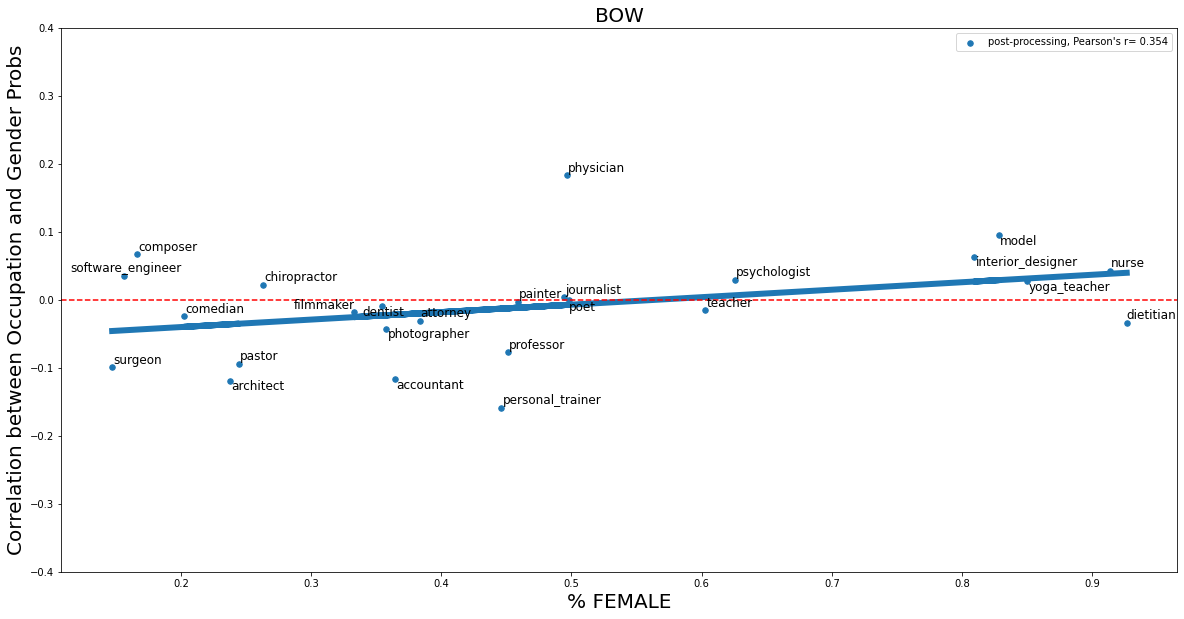

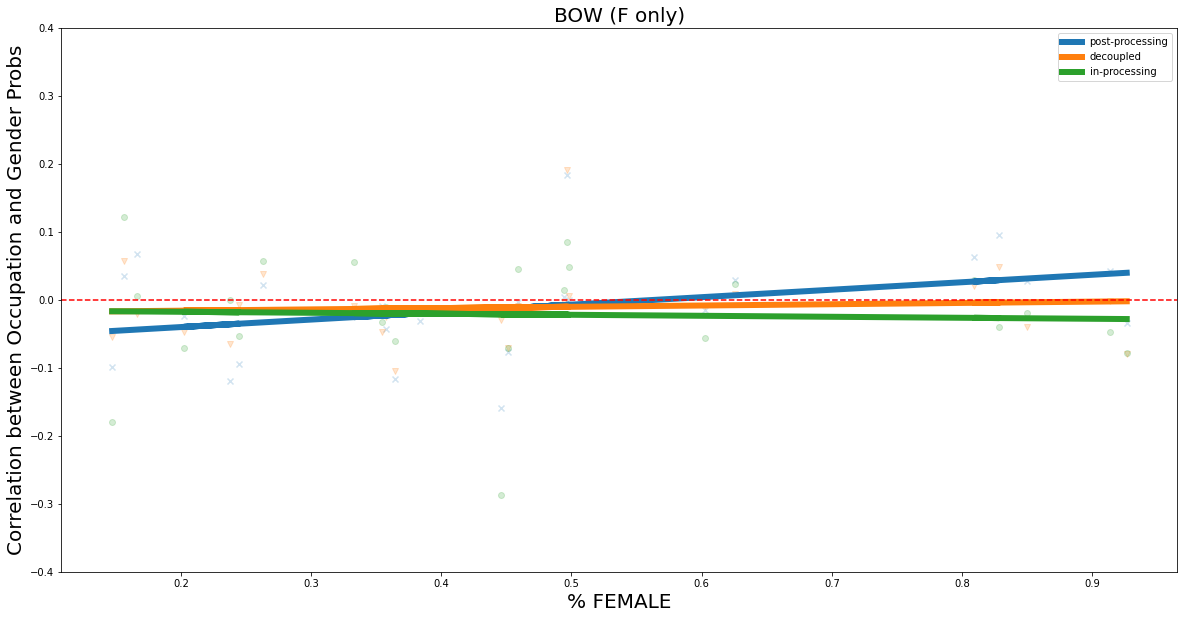

In [105]:
# plot comaprison

pylab.rcParams['figure.figsize'] = (20, 10)
xs = np.array(f_frac).reshape(-1,)

m, b = np.polyfit(xs, np.array(joint_corr).reshape(-1,), 1)
plt.scatter(f_frac,joint_corr,marker='o',s=30,label='post-processing, Pearson\'s r= %.3f'%(scipy.stats.pearsonr( f_frac,joint_corr)[0]))
plt.plot(xs, m*xs+ b,linewidth=6)

plt.legend()

plt.axhline(y=0, color='r', linestyle='dashed')


x_label = "% FEMALE"
y_label = 'Correlation between Occupation and Gender Probs'
texts = [plt.text(x,y,l,size=12) for x, y, l in zip(f_frac, joint_corr, occs)]
adjust_text(texts)
xlabel(x_label,size = 20 )
ylabel(y_label, size=20)
plt.ylim([-0.4, 0.4])
plt.title("BOW",fontsize=20)
    
plt.figure()
    

pylab.rcParams['figure.figsize'] = (10, 10)
xs = np.array(f_frac).reshape(-1,)

m, b = np.polyfit(xs, np.array(joint_corr).reshape(-1,), 1)
plt.scatter(f_frac,joint_corr,marker='x',alpha=0.2)
plt.plot(xs, m*xs+ b,linewidth=6,label='post-processing')

m, b = np.polyfit(xs, np.array(decoupled_corr).reshape(-1,), 1)
plt.scatter(f_frac,decoupled_corr,marker='v',alpha=0.2)
plt.plot(xs, m*xs+ b,linewidth=6,label='decoupled')


m, b = np.polyfit(xs, np.array(eo_corr).reshape(-1,), 1)
plt.scatter(f_frac,eo_corr,alpha=0.2)
plt.plot(xs, m*xs+ b,linewidth=6,label='in-processing')
plt.legend()


plt.axhline(y=0, color='r', linestyle='dashed')

x_label = "% FEMALE"
y_label = 'Correlation between Occupation and Gender Probs'
# texts = [plt.text(x,y,l) for x, y, l in zip(f_frac, decoupled_corr, occs)]
adjust_text(texts)
xlabel(x_label,size = 20 )
ylabel(y_label, size=20)
plt.ylim([-0.4, 0.4])
plt.title("BOW (F only)",fontsize=20)
    

    

In [106]:
def get_color_gradient(xs,ys,inv=False):
    CB_color_cycle = [(0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
(1.0, 0.4980392156862745, 0.0),
(0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
(0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
(0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
(0.596078431372549, 0.3058823529411765, 0.6392156862745098),
(0.6, 0.6, 0.6),
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
(0.8705882352941177, 0.8705882352941177, 0.0),]
    dists = np.array([min(abs(i),abs(j)) for i,j in zip(xs,ys)])
    dists = dists/max(dists)
    if inv:
        lightness = [min(1,round(d,2)+0.15) for d in dists]
    else:
        lightness = [1-round(d,2) for d in dists]
#     print(lightness)

    colors = []
    markers = []
    for x,y,l in zip(xs,ys,lightness):
        if x > 0:
            if y > 0:
                c = CB_color_cycle[0] + (l,) #(r,g,b,alpha)
            else:
                c = CB_color_cycle[1] + (l,)
        else:
            if y > 0:
                c = CB_color_cycle[2] + (l,)
            else: 
                c = CB_color_cycle[3] + (l,)
        colors.append(c)
#     print(colors)
#     plt.scatter(xs,ys,c=colors)
    return colors

In [373]:
balanced_gender_clf = pkl.load(open('results/bow_bal_g.pkl','rb'))


In [156]:
# using fairlearn with equalized odds - doesnt reduce the EO gap, possibly because it doesnt work with large/sparse vectors?
from fairlearn.metrics import equalized_odds_difference
occs = ["surgeon", "software_engineer", "composer", "pastor", "comedian", "architect", "chiropractor", "accountant", "attorney", "filmmaker", "physician", "dentist", "photographer", "professor", "painter", "journalist", "poet", "personal_trainer", "teacher", "psychologist",  "model", "interior_designer", "yoga_teacher", "nurse", "dietitian"]

for target_occ in occs:
    Y_test = [p["title"]==target_occ for p in bios_data_test]
    y_pred_unmit = occ_classers[target_occ]['clf_bow_joint'].predict(X_test)

    y_pred_eo =  np.argmax(y_preds_eo[target_occ],axis=1)==1#[:,1]
    print("%s --- original: %.3f, after in-processing: %.3f" % (target_occ, equalized_odds_difference(Y_test, y_pred_unmit, sensitive_features=G_test), equalized_odds_difference(Y_test, y_pred_eo, sensitive_features=G_test))
         )

surgeon --- original: 0.052, after in-processing: 0.166
software_engineer --- original: 0.058, after in-processing: 0.045
composer --- original: 0.018, after in-processing: 0.025
pastor --- original: 0.035, after in-processing: 0.046
comedian --- original: 0.013, after in-processing: 0.016
architect --- original: 0.048, after in-processing: 0.039
chiropractor --- original: 0.052, after in-processing: 0.077
accountant --- original: 0.008, after in-processing: 0.018
attorney --- original: 0.002, after in-processing: 0.017
filmmaker --- original: 0.006, after in-processing: 0.023
physician --- original: 0.051, after in-processing: 0.046
dentist --- original: 0.008, after in-processing: 0.014
photographer --- original: 0.001, after in-processing: 0.003
professor --- original: 0.004, after in-processing: 0.007
painter --- original: 0.008, after in-processing: 0.003
journalist --- original: 0.014, after in-processing: 0.023
poet --- original: 0.021, after in-processing: 0.023
personal_traine

In [160]:
# examining difference in EO gap. this is old/not used in the paper, which focuses on RMS gap.
from fairlearn.metrics import equalized_odds_difference

# y_preds_eo = pkl.load(open('results/we_eo_y_preds.pkl','rb'))
originals = []
eos = []
decoupled=[]
#equalized odds
# cand_women_X =  [word_vector_featurize(p['bio'], E) for p in bios_data_test]

for target_occ in occs:
    Y_test = [p["title"]==target_occ for p in bios_data_test]
    y_pred_unmit = occ_classers[target_occ]['clf_bow_joint'].predict(X_test)
    f_inds = [p["title"]=='F' for p in bios_data_test]
    
    
    #todo decoupled
    y_preds_f = occ_classers[target_occ]['clf_bow_f'].predict(X_test)
    y_preds_m = occ_classers[target_occ]['clm_bow_m'].predict(X_test)
    y_preds_m[f_inds] = y_preds_f[f_inds]

    
#     corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
#     decoupled_corr_full.append(corr)

    y_pred_eo =  np.argmax(y_preds_eo[target_occ],axis=1)==1#[:,1]
    
    a=equalized_odds_difference(Y_test, y_pred_unmit, sensitive_features=G_test)
    b=equalized_odds_difference(Y_test, y_pred_eo, sensitive_features=G_test)
    
    c = equalized_odds_difference(Y_test, y_preds_m, sensitive_features=G_test)
#     y_pred_unmit = bal_occers[target_occ]['clf_bow_joint'].predict(X_test)
    originals.append(a)
    eos.append(b)
    decoupled.append(c)
#     y_pred_eo = eo_mitigators_bal[target_occ].predict(X_test)
    print("%s --- original: %.3f, after in-processing: %.3f" % (target_occ, a, b)
         )

surgeon --- original: 0.052, after in-processing: 0.166
software_engineer --- original: 0.058, after in-processing: 0.045
composer --- original: 0.018, after in-processing: 0.025
pastor --- original: 0.035, after in-processing: 0.046
comedian --- original: 0.013, after in-processing: 0.016
architect --- original: 0.048, after in-processing: 0.039
chiropractor --- original: 0.052, after in-processing: 0.077
accountant --- original: 0.008, after in-processing: 0.018
attorney --- original: 0.002, after in-processing: 0.017
filmmaker --- original: 0.006, after in-processing: 0.023
physician --- original: 0.051, after in-processing: 0.046
dentist --- original: 0.008, after in-processing: 0.014
photographer --- original: 0.001, after in-processing: 0.003
professor --- original: 0.004, after in-processing: 0.007
painter --- original: 0.008, after in-processing: 0.003
journalist --- original: 0.014, after in-processing: 0.023
poet --- original: 0.021, after in-processing: 0.023
personal_traine

In [334]:
# get prediction summaries for each one

originals_occ = []
pr_occ = []
decoupled_occ=[]
#equalized odds
# cand_women_X =  [word_vector_featurize(p['bio'], E) for p in bios_data_test]

for target_occ in occs:
    temp_inds = [i for i,p in enumerate(bios_data_test)]
    Y_test = [p["title"]==target_occ for p in np.array(bios_data_test)[temp_inds]]
#     print(np.unique(np.array(Y_test)))
    y_pred_unmit = occ_classers[target_occ]['clf_bow_joint'].predict(X_test[temp_inds])
    f_inds = [p["gender"]=='F' for p in np.array(bios_data_test)[temp_inds]]
    
    #decoupled
    y_preds_f = occ_classers[target_occ]['clf_bow_f'].predict(X_test[temp_inds])
    y_preds_m = occ_classers[target_occ]['clm_bow_m'].predict(X_test[temp_inds])
    y_preds_m[f_inds] = y_preds_f[f_inds]

    
    G_test = np.array(G_test)
    y_pred_pr = occ_classers[target_occ]['clf_bow_joint_sampleweights'].predict(X_test[temp_inds])
    a=pred_summary(y_pred_unmit, Y_test, G_test[temp_inds])
    
    b=pred_summary(y_preds_m, Y_test, G_test[temp_inds])
    c=pred_summary(y_pred_pr, Y_test, G_test[temp_inds])
    originals_occ.append(a)
    pr_occ.append(c)
    decoupled_occ.append(b)

In [236]:
#takes as input a dictionary that is outputed by cv_pred()
def pred_summary(pred_dic, Y_test, G_test):
    #wildcard aggregates over different classes/genders
    wildcard = "*"
    genders = sorted(set(G_test)) + [wildcard]
    ys = sorted(set(Y_test)) + [wildcard]
    summary =  {y: {g: [] for g in genders} for y in ys} 
    for y in ys:
        for gender in genders:
            #print(y,sum(array(Y_test)==y))
            #accuracies = []
            bool_subgroup = [y_pred==y_true for y_pred, y_true, g in zip(pred_dic, Y_test, G_test) 
                        if (gender==wildcard or gender==g) and (y==wildcard or y==y_true)]
            acc=mean(bool_subgroup)
            summary[y][gender]=acc    
    return summary

In [335]:
orig_gap = []
for p in originals_occ:
    orig_gap.append(p[True]['F']-p[True]['M'])
orig_gap=np.array(orig_gap)
dec_gap = []
for p in decoupled_occ:
    dec_gap.append(p[True]['F']-p[True]['M'])
dec_gap=np.array(dec_gap)
pr_gap = []
for p in pr_occ:
    pr_gap.append(p[True]['F']-p[True]['M'])
pr_gap=np.array(pr_gap)

In [336]:
np.sqrt(np.sum(orig_gap**2)/len(orig_gap))

0.07198103758559725

In [337]:
np.sqrt(np.sum(dec_gap**2)/len(dec_gap))

0.10412997852188982

In [338]:
np.sqrt(np.sum(pr_gap**2)/len(pr_gap))

0.07826257488776606

In [249]:

#takes as input a dictionary that is outputed by cv_pred()
def get_pred_summary(pred_dic, Y_test, G_test):
    #wildcard aggregates over different classes/genders
    wildcard = "*"
    genders = sorted(set(G_test)) + [wildcard]
    ys = sorted(set(Y_test)) + [wildcard]
    summary =  {y: {g: [] for g in genders} for y in ys} 
    for y in ys:
        for gender in genders:
            #print(y,sum(array(Y_test)==y))
            #accuracies = []
            bool_subgroup = [y_pred==y_true for y_pred, y_true, g in zip(pred_dic, Y_test, G_test) 
                        if (gender==wildcard or gender==g) and (y==wildcard or y==y_true)]
            acc=mean(bool_subgroup)
            summary[y][gender]=acc    
    return summary

In [ ]:
orig_gap = []
for p in originals_occ:
    orig_gap.append(p[True]['F']-p[True]['M'])
orig_gap=np.array(orig_gap)
dec_gap = []
for p in decoupled_occ:
    dec_gap.append(p[True]['F']-p[True]['M'])
dec_gap=np.array(dec_gap)
eo_gap = []
for p in eos_occ:
    eo_gap.append(p[True]['F']-p[True]['M'])
eo_gap=np.array(eo_gap)

In [278]:
# get accuracy of decoupled classifiers
accs = []
for target_occ in occs:
    Y_test = [p["title"]==target_occ for p in bios_data_test if p['gender']=='F']
    
    accs.append(sklearn.metrics.accuracy_score(Y_test,occ_classers[target_occ]['clf_bow_f'].predict(f_X_test)))
print(np.mean(accs))


accs = []
for target_occ in occs:
    Y_test = [p["title"]==target_occ for p in bios_data_test if p['gender']=='M']
    
    accs.append(sklearn.metrics.accuracy_score(Y_test,occ_classers[target_occ]['clm_bow_m'].predict(m_X_test)))
print(np.mean(accs))

(0.9621172477968143+0.9526)/2


0.9621172477968143


In [339]:

accs=[]
for target_occ in occs:
    
    G_test = [p["title"]==target_occ for p in bios_data_test]
    
    accs.append(sklearn.metrics.accuracy_score(Y_test,occ_classers[target_occ]['clf_bow_joint_sampleweights'].predict(X_test)))
np.mean(accs)

0.9160021110301324

In [287]:
# get accuracy of 25-way classifiers
Y_test = [p["title"] for p in bios_data_test]
sklearn.metrics.accuracy_score(Y_test,occ_classers['all']['clf_bow_joint'].predict(X_test))

0.7725867658515745

In [288]:
Y_test = [p["title"] for p in bios_data_test if p['gender']=='F']
sklearn.metrics.accuracy_score(Y_test,occ_classers['all']['clf_bow_f'].predict(f_X_test))

0.7782308829164157

In [303]:
m_Y_test = [p["title"] for p in m_bios_test]
# Y_test = [p["title"] for p in bios_data_test if p['gender']=='M']
sklearn.metrics.accuracy_score(m_Y_test,clm_bow_m.predict(m_X_test))

0.7724189201747049

In [300]:
clm_bow_m.predict(m_X_test)

array([False, False, False, ..., False, False, False])

In [304]:
(0.7782308829164157+0.77241)/2

0.7753204414582079

# train BOW-PR classifier

In [305]:


occs_full = np.unique([p['title'] for p in bios_data_train])
#make sample weights
# sample_weights=[]
valdict = {}
for t in occs_full:
        fval = _m[t] / max(_f[t],_m[t])
        mval = _f[t] / max(_f[t],_m[t])
        valdict[t] = {}
        valdict[t]['F'] = fval
        valdict[t]['M'] = mval
    
# for :
sample_weights = np.array([valdict[p['title']][p['gender']] for p in bios_data_train])

#  n_samples / (n_classes * np.bincount(​y)
# Train Occupation classifiers



# occ_classers = {}

occs = ["surgeon", "software_engineer", "composer", "pastor", "comedian", "architect", "chiropractor", "accountant", "attorney", "filmmaker", "physician", "dentist", "photographer", "professor", "painter", "journalist", "poet", "personal_trainer", "teacher", "psychologist",  "model", "interior_designer", "yoga_teacher", "nurse", "dietitian"]
for target_occ in occs:
    Y_train = [p["title"]==target_occ for p in bios_data_train]

    Y_val = [p["title"]==target_occ for p in bios_data_val]

    Y_test = [p["title"]==target_occ for p in bios_data_test]
    
    classweights = len(Y_train)/np.bincount(Y_train)
    
    
    class_weights_arr = np.array([classweights[int(k)] for k in Y_train])
    bal_sample_weights = sample_weights * class_weights_arr
    pred_bow_joint, clf_bow_joint = pred_clf([X_train, X_val, X_test], [Y_train, Y_val, Y_test], [G_train,G_val,G_test],sweights=bal_sample_weights)

    
#     occ_classers[target_occ] = {}
    occ_classers[target_occ]['clf_bow_joint_sampleweights'] = clf_bow_joint
#     occ_classers[target_occ]['pred_bow_joint'] = pred_bow_joint
#     occ_classers[target_occ]['clf_bow_f'] = clf_bow_f
#     occ_classers[target_occ]['pred_bow_f'] = pred_bow_f


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


In [306]:
f_frac = np.load('results/f_frac.npy')
y_preds_eo = pkl.load(open('results/bow_eo_y_preds.pkl','rb'))
prep_corr_full = []
# decoupled_corr_full = []
# eo_corr_full = []
for target_occ in occs:
    
    
    cand_women = [p for p in bios_data_test if p["title"]==target_occ and p['gender']=='F']
#     cand_women_X =  single_vectorizers[target_occ].transform([p["bio"] for p in cand_women])
    
    cand_women_X_full =  vectorizer.transform([p["bio"] for p in cand_women])
    
    gender_probs = balanced_gender_clf.predict_proba(cand_women_X_full)[:,0]
    occ_probs = occ_classers[target_occ]['clf_bow_joint_sampleweights'].predict_proba(cand_women_X_full)[:,1]
    
    
    
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    prep_corr_full.append(corr)
    

In [403]:
print(np.cov(f_frac,prep_corr_full[:25])[0,1])

0.023586925748631072


# get gendered words

In [465]:
'youtube' in chi_vectorizers[target_occ][thr].vocabulary

True

In [520]:
words = np.array(vectorizer.get_feature_names())
occs = ["surgeon", "software_engineer", "composer", "yoga_teacher", "nurse", "dietitian"]
all_proxy_words = []
for target_occ in occs:
    print(target_occ.upper())
    gender_dots = balanced_gender_clf.coef_[0]
    f_dots = occ_classers[target_occ]['clf_bow_f'].coef_[0]
    m_dots = occ_classers[target_occ]['clm_bow_m'].coef_[0]
    j_dots = occ_classers[target_occ]['clf_bow_joint'].coef_[0]
    
    small_thr = 0.7
    gender_thr = 0.4
    actual_thr = gender_thr
    #feminine
    inds = np.where(((abs(f_dots) < small_thr*abs(j_dots)) & (abs(m_dots) < small_thr*abs(j_dots))) & ((gender_dots < -gender_thr) & (abs(j_dots)>actual_thr)))[0]
    print(words[inds])
#     for w in words[inds]:
#         if w in chi_vectorizers[target_occ][thr].vocabulary:
#             print(w)
#     print(gender_dots[inds])
    #masculine
    all_proxy_words.extend(words[inds])
    inds = np.where(((abs(f_dots) < small_thr*abs(j_dots)) & (abs(m_dots) < small_thr*abs(j_dots))) & ((gender_dots >gender_thr) & (abs(j_dots)>actual_thr)))[0]

    print(words[inds])
    
#     for w in words[inds]:
#         if w in chi_vectorizers[target_occ][thr].vocabulary:
#             print(w)

#     print(j_dots[inds])
    all_proxy_words.extend(words[inds])
#     print(j_dots[inds]-f_dots[inds])
print(set(all_proxy_words))

SURGEON
[]
['wife']
SOFTWARE_ENGINEER
[]
['wife']
COMPOSER
['freeones' 'woman']
[]
YOGA_TEACHER
['baby' 'husband' 'loves' 'mom']
[]
NURSE
['husband' 'miss' 'mother']
[]
DIETITIAN
[]
['wife']
{'miss', 'loves', 'mom', 'wife', 'woman', 'mother', 'freeones', 'baby', 'husband'}


In [480]:
set(['wife', 'wife', 'baby', 'breast', 'freeones', 'man', 'breast', 'husband', 'gender', 'miss', 'miss', 'sports', 'baby', 'husband', 'loves', 'miss', 'mother', 'wife'])

{'baby',
 'breast',
 'freeones',
 'gender',
 'husband',
 'loves',
 'man',
 'miss',
 'mother',
 'sports',
 'wife'}

In [521]:
words = np.array(vectorizer.get_feature_names())
# occs = ["surgeon", "software_engineer", "composer", "pastor", "comedian", "architect", "chiropractor", "accountant", "attorney", "filmmaker", "physician", "dentist", "photographer", "professor", "painter", "journalist", "poet", "personal_trainer", "teacher", "psychologist",  "model", "interior_designer", "yoga_teacher", "nurse", "dietitian"]
all_proxy_words = []
for target_occ in occs:
    print(target_occ)
    gender_dots = balanced_gender_clf.coef_[0]
    f_dots = occ_classers[target_occ]['clf_bow_f'].coef_[0]
    m_dots = occ_classers[target_occ]['clm_bow_m'].coef_[0]
    j_dots = occ_classers[target_occ]['clf_bow_joint'].coef_[0]
    
    small_thr = 0.7
    gender_thr = 0.4
    #feminine
    inds = np.where(((abs(j_dots) < small_thr*abs(f_dots)) & (abs(j_dots) < small_thr*abs(m_dots))) & ((gender_dots < -gender_thr) & (abs(f_dots)>gender_thr)))[0]
    print(words[inds])
    all_proxy_words.extend(words[inds])
    #masculine
    inds = np.where(((abs(j_dots) < small_thr*abs(f_dots)) & (abs(j_dots) < small_thr*abs(m_dots))) & ((gender_dots >gender_thr) & (abs(f_dots)>gender_thr)))[0]

    print(words[inds])
    all_proxy_words.extend(words[inds])
#     print(j_dots[indsextef_dots[inds])
print(set(all_proxy_words))

surgeon
['anthologies' 'daughter' 'female']
[]
software_engineer
['daughter' 'loves' 'romance' 'sister' 'women']
[]
composer
['girls' 'loves' 'mother']
[]
yoga_teacher
[]
[]
nurse
[]
[]
dietitian
['gender' 'women']
['men']
{'girls', 'women', 'gender', 'loves', 'men', 'mother', 'romance', 'daughter', 'sister', 'anthologies', 'female'}


# Nonbinary bios

In [362]:
import pandas as pd
nb_bios = pd.read_pickle('results/nb_prof.pkl')
nb_bios_list = list(nb_bios['bio'])

In [430]:
target_occ='professor'
cand_women_X_full =  vectorizer.transform(nb_bios_list)
gender_probs = balanced_gender_clf.predict_proba(cand_women_X_full)[:,0]

occ_probs = occ_classers[target_occ]['clf_bow_joint'].predict_proba(cand_women_X_full)[:,1]
corr = spearmanr(occ_probs,gender_probs)
print("joint")
print(corr)

occ_probs = occ_classers[target_occ]['clf_bow_joint_sampleweights'].predict_proba(cand_women_X_full)[:,1]
corr = spearmanr(occ_probs,gender_probs)
print("pre-processing")
print(corr)

occ_probs = occ_classers[target_occ]['clf_bow_f'].predict_proba(cand_women_X_full)[:,1]
corr = spearmanr(occ_probs,gender_probs)
print("decoupled F")
print(corr)


cc_probs = occ_classers[target_occ]['clm_bow_m'].predict_proba(cand_women_X_full)[:,1]
corr = spearmanr(occ_probs,gender_probs)
print("decoupled M")
print(corr)

joint
SpearmanrResult(correlation=0.34285714285714286, pvalue=0.12813141007326165)
pre-processing
SpearmanrResult(correlation=0.3571428571428571, pvalue=0.11198091415054655)
decoupled F
SpearmanrResult(correlation=0.3532467532467533, pvalue=0.11623101293161812)
decoupled M
SpearmanrResult(correlation=0.3532467532467533, pvalue=0.11623101293161812)


In [518]:
bios_data_test[0]['gender']

'F'

In [519]:
target_occ='professor'
cand_women_X_full =  vectorizer.transform([p['bio'] for p in bios_data_test if p['title']=='professor' and p['gender']=='F'])
gender_probs = balanced_gender_clf.predict_proba(cand_women_X_full)[:,0]

occ_probs = occ_classers[target_occ]['clf_bow_joint'].predict_proba(cand_women_X_full)[:,1]
corr = spearmanr(occ_probs,gender_probs)
print("joint")
print(corr)

occ_probs = occ_classers[target_occ]['clf_bow_joint_sampleweights'].predict_proba(cand_women_X_full)[:,1]
corr = spearmanr(occ_probs,gender_probs)
print("pre-processing")
print(corr)

occ_probs = occ_classers[target_occ]['clf_bow_f'].predict_proba(cand_women_X_full)[:,1]
corr = spearmanr(occ_probs,gender_probs)
print("decoupled F")
print(corr)


cc_probs = occ_classers[target_occ]['clm_bow_m'].predict_proba(cand_women_X_full)[:,1]
corr = spearmanr(occ_probs,gender_probs)
print("decoupled M")
print(corr)

joint
SpearmanrResult(correlation=0.09885271218328551, pvalue=1.335680693321492e-24)
pre-processing
SpearmanrResult(correlation=0.09299780959247775, pvalue=6.021316047062975e-22)
decoupled F
SpearmanrResult(correlation=0.11061599255311397, pvalue=2.0061629073790192e-30)
decoupled M
SpearmanrResult(correlation=0.11061599255311397, pvalue=2.0061629073790192e-30)


In [402]:
joint_corr_full

[]

In [427]:

print(spearmanr(f_frac,prep_corr_full[:25]))
print(spearmanr(f_frac,decoupled_corr_full[:25]))



print(pearsonr(f_frac,joint_corr_full[:25])[0])
print(pearsonr(f_frac,decoupled_corr_full[:25])[0])

SpearmanrResult(correlation=0.7184615384615384, pvalue=5.2320590537914136e-05)
SpearmanrResult(correlation=0.5876923076923077, pvalue=0.00200697959282309)


TypeError: pearsonr() takes 1 positional argument but 2 were given

In [417]:
imbalanced_inds  = np.where(abs(f_frac-0.5)>0.25)[0]
def imb_pearsonr(l):
#     print("Pearson's r")
    print(scipy.stats.pearsonr(f_frac[imbalanced_inds],np.array(l)[imbalanced_inds])[0])
    
def imb_cov(l):
#     print("Covariance")
    print(np.cov(f_frac[imbalanced_inds],np.array(l)[imbalanced_inds])[0,1]) 
    
def imb_spear(l):
#     print("Spearman's r")
    print(scipy.stats.spearmanr(f_frac[imbalanced_inds],np.array(l)[imbalanced_inds])[0])

In [419]:

imb_pearsonr(joint_corr)
imb_pearsonr(decoupled_corr)
imb_pearsonr(pr_corr)

imb_spear(joint_corr)
imb_spear(decoupled_corr)
imb_spear(pr_corr)

imb_cov(joint_corr)
imb_cov(decoupled_corr)
imb_cov(pr_corr)

0.7499726103002508
0.45676013374226826
0.6678269664711861
0.8181818181818182
0.5909090909090909
0.5545454545454546
0.04015085866749381
0.019894551957214138
0.0363622388494538


In [420]:

imb_pearsonr(joint_corr_full)
imb_pearsonr(decoupled_corr_full)
imb_pearsonr(pr_corr_full)

imb_spear(joint_corr_full)
imb_spear(decoupled_corr_full)
imb_spear(pr_corr_full)

imb_cov(joint_corr_full)
imb_cov(decoupled_corr_full)
imb_cov(pr_corr_full)

0.8554871888949841
0.6789301381098164
0.7565220643229954
0.790909090909091
0.6727272727272727
0.6000000000000001
0.06297854792538034
0.040783012155025
0.05624642706317887


In [424]:
# imbalanced_inds  = np.where(abs(f_frac-0.5)>0.25)[0]
def pearsonr(l):
#     print("Pearson's r")
    print(scipy.stats.pearsonr(f_frac,np.array(l))[1])
    
def cov(l):
#     print("Covariance")
    print(np.cov(f_frac,np.array(l))[0,1]) 
    
def spear(l):
#     print("Spearman's r")
    print(scipy.stats.spearmanr(f_frac,np.array(l)))

In [425]:

pearsonr(joint_corr_full)
pearsonr(decoupled_corr_full)
pearsonr(pr_corr_full)

spear(joint_corr_full)
spear(decoupled_corr_full)
spear(pr_corr_full)

cov(joint_corr_full)
cov(decoupled_corr_full)
cov(pr_corr_full)

1.3450978871476565e-05
0.0035611619157176204
0.00018019973570235906
SpearmanrResult(correlation=0.7646153846153846, pvalue=8.574570332971608e-06)
SpearmanrResult(correlation=0.5876923076923077, pvalue=0.00200697959282309)
SpearmanrResult(correlation=0.6123076923076923, pvalue=0.0011407067477000074)
0.029388894783363904
0.01957441017331686
0.0262263870666854


In [426]:
spear(joint_corr)
spear(decoupled_corr)
spear(pr_corr)

SpearmanrResult(correlation=0.5884615384615385, pvalue=0.0019731836136078363)
SpearmanrResult(correlation=0.3253846153846154, pvalue=0.11247376203917941)
SpearmanrResult(correlation=0.46384615384615385, pvalue=0.01951476779247493)
